# Sync

In [1]:
!aws s3 sync resources/ s3://openproblems-data/resources/grn/ --delete
# !aws s3 sync resources/grn_models/ s3://openproblems-data/resources/grn/grn_models --delete
# !aws s3 sync resources/prior/ s3://openproblems-data/resources/grn/prior --delete
# !aws s3 sync resources/results/ s3://openproblems-data/resources/grn/results --delete
# !aws s3 sync resources/scores/ s3://openproblems-data/resources/grn/scores --delete
# !aws s3 sync  resources/evaluation_datasets/ s3://openproblems-data/resources/grn/evaluation_datasets/ --delete
# !aws s3 sync  resources/inference_datasets/ s3://openproblems-data/resources/grn/inference_datasets/ --delete

upload: resources/datasets_raw/adamson_bulked.h5ad to s3://openproblems-data/resources/grn/datasets_raw/adamson_bulked.h5ad
upload: resources/datasets_raw/norman_bulked.h5ad to s3://openproblems-data/resources/grn/datasets_raw/norman_bulked.h5ad
delete: s3://openproblems-data/resources/grn/datasets_raw/op_perturbation_counts.h5ad  
upload: resources/datasets_raw/nakatake_bulked.h5ad to s3://openproblems-data/resources/grn/datasets_raw/nakatake_bulked.h5ad
upload: resources/datasets_raw/op_bulked.h5ad to s3://openproblems-data/resources/grn/datasets_raw/op_bulked.h5ad
delete: s3://openproblems-data/resources/grn/datasets_raw/replogle2.h5ad            
upload: resources/datasets_raw/adamson_sc_counts.h5ad to s3://openproblems-data/resources/grn/datasets_raw/adamson_sc_counts.h5ad
upload: resources/evaluation_datasets/adamson_perturbation.h5ad to s3://openproblems-data/resources/grn/evaluation_datasets/adamson_perturbation.h5ad
upload: resources/evaluation_datasets/nakatake_perturbation.h

In [ ]:
!aws s3 sync  s3://openproblems-data/resources/grn/ resources/ --delete

aws s3 sync s3://openproblems-data/resources/grn/results  resources/results/ --delete

aws s3 sync  s3://openproblems-data/resources/grn/grn_models resources/grn_models/

aws s3 sync  s3://openproblems-data/resources/grn/inference_datasets/ resources/inference_datasets/

aws s3 sync  s3://openproblems-data/resources/grn/evaluation_datasets/ resources/evaluation_datasets/

In [4]:
# !aws s3 sync resources_test/ s3://openproblems-data/resources_test/grn/ --delete
# !aws s3 sync resources/inference_datasets/ s3://openproblems-data/resources/grn/inference_datasets/ --delete

# Import

In [2]:
%reload_ext autoreload
%autoreload 2
import yaml
import os
import pandas as pd
import anndata as ad 
import numpy as np
import scanpy as sc 
from src.exp_analysis.helper import plot_cumulative_density
import matplotlib.pyplot as plt
import sys 
import subprocess
import io
import warnings
from tqdm import tqdm

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


sys.path.append('../')
from grn_benchmark.src.helper import surragate_names
from src.helper import *
par = {
    # 'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'genie3', 'grnboost2', 'scenic', 'scglue', 'celloracle'],
    'methods': [ 'collectri', 'negative_control', 'positive_control', 'pearson_corr', 'portia', 'ppcor', 'grnboost2', 'scenic', 'scglue', 'celloracle', 'scenicplus'],
    'models_dir': 'resources/grn_models/',
    'scores_dir': 'resources/scores'
}

datasets = ['op', 'replogle2', 'nakatake', 'norman', 'adamson']

# Subsample

In [11]:
df = pd.read_csv(f'resources/scores/op/subsampled.csv', index_col=0)
df.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0
pearson_corr_1,0.530897,0.970276,0.568970,0.436350,0.367186
pearson_corr_2,0.532218,0.983027,0.583044,0.439533,0.368858


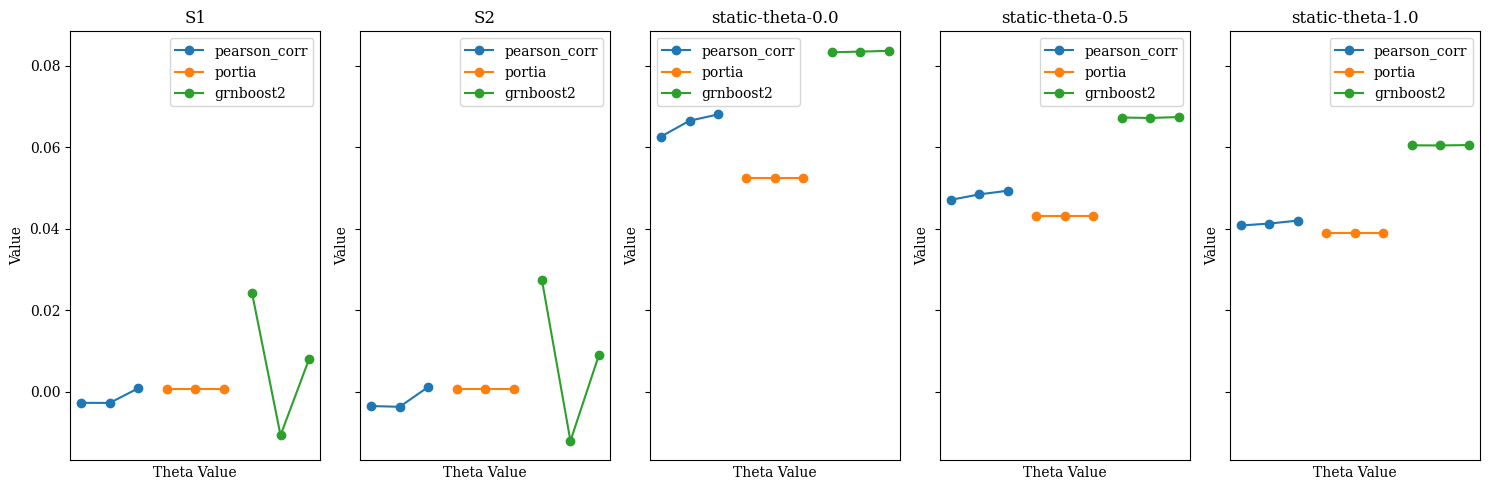

In [10]:

theta_values = [0.2, 0.5, 1.0]
methods = ['pearson_corr', 'portia', 'grnboost2']

# Prepare the figure with subplots (one for each column in df)
fig, axes = plt.subplots(1, len(df.columns), figsize=(15, 5), sharey=True)

# Loop through each column and plot
for i, col in enumerate(df.columns):
    ax = axes[i]
    
    # Plot each method's line for the current subplot
    for method in methods:
        # Filter out the rows that match the current method
        method_rows = df.index.str.contains(method)
        
        # Get the values corresponding to theta values (0.2, 0.5, 1.0)
        method_data = df.loc[method_rows, col]
        
        # Drop missing values (NaN) and plot
        method_data = method_data.dropna()
        
        # Plot only if there are available data points
        if len(method_data) > 0:
            ax.plot(method_data.index, method_data.values, marker='o', label=method)
    
    # Set labels and title for each subplot
    ax.set_title(f'{col}')
    ax.set_xlabel('Theta Value')
    ax.set_ylabel('Value')
    ax.set_xticks([])
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Prior 

In [7]:
if False: 
    create_skeleton() # create tf2gene putative links

# Run grn inference 

In [8]:
if False: # local runs
    run_grn_inference()

# Calculate scores

In [9]:
from src.helper import calculate_scores
if False: # consensus: run this after updating grns
    run_consensus(par)

if False: # run metrics/script_all.py
    calculate_scores()

# Regression scores

### OPSCA

#### Ridge

In [12]:
df_scores = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global_False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

FileNotFoundError: [Errno 2] No such file or directory: 'resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global_False.csv'

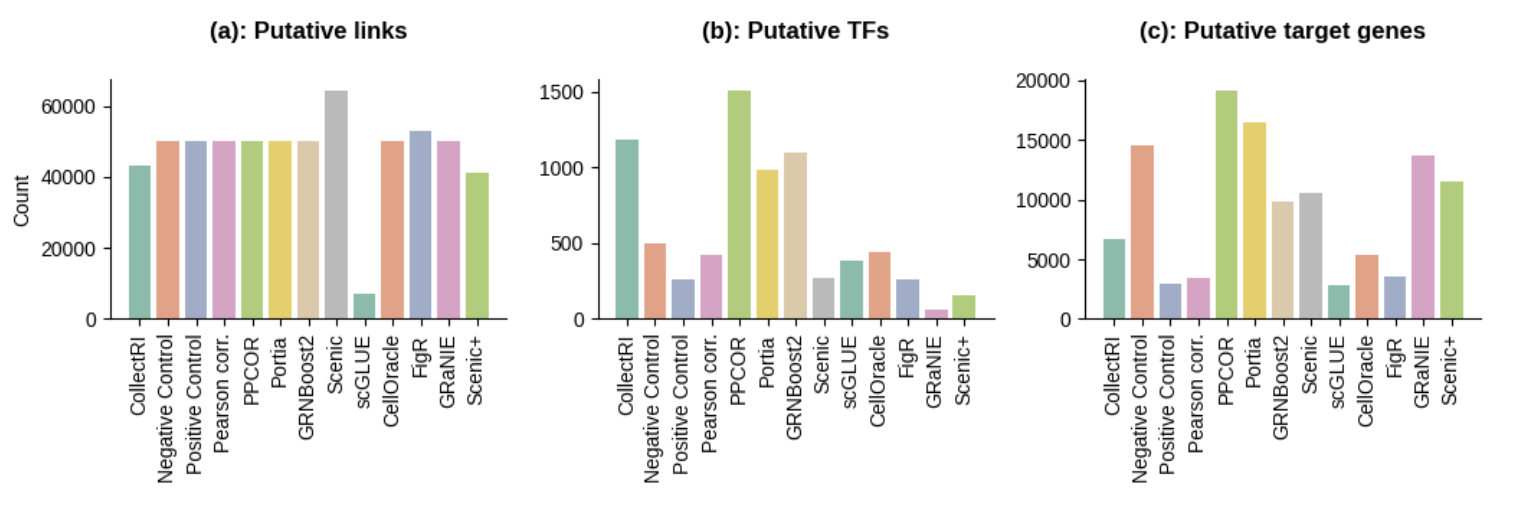

#### GB

In [3]:
df_scores = pd.read_csv(f"resources/scores/op/50000-skeleton_False-binarize_True-GB.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,rank
collectri,0.037785,0.082205,0.282480,0.294742,11
negative_control,0.000440,0.000459,0.260926,0.302373,12
positive_control,0.671630,1.106263,0.739857,0.420285,1
pearson_corr,0.546758,1.005020,0.682991,0.396617,3
portia,0.317483,0.459731,0.595570,0.345240,7
ppcor,0.097117,0.117754,0.396929,0.306533,10
grnboost2,0.653354,0.819973,0.658351,0.493956,2
scenic,0.219697,0.325873,0.596756,0.441442,6
granie,0.084081,0.110564,0.172862,0.211528,13
scglue,0.105952,0.462190,0.581289,0.316301,9


### replogle2

In [6]:
df_scores = pd.read_csv(f"resources/scores/replogle2/50000-skeleton_False-binarize_True-ridge.csv", index_col=0)
# df_scores[df_scores<0] = 0

df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,0.007890,0.007940,0.004070,0.007549,0.016413,7
positive_control,0.014413,0.019584,0.070334,0.051472,0.043955,2
pearson_corr,-0.008077,-0.010913,0.068009,0.049308,0.041981,3
portia,0.005164,0.005206,0.052368,0.043075,0.039028,4
ppcor,-0.025308,-0.025607,0.007153,0.009689,0.017616,6
grnboost2,-0.007698,-0.008728,0.083347,0.067546,0.060886,1
scenic,0.005057,0.006892,0.031547,0.021333,0.023515,5


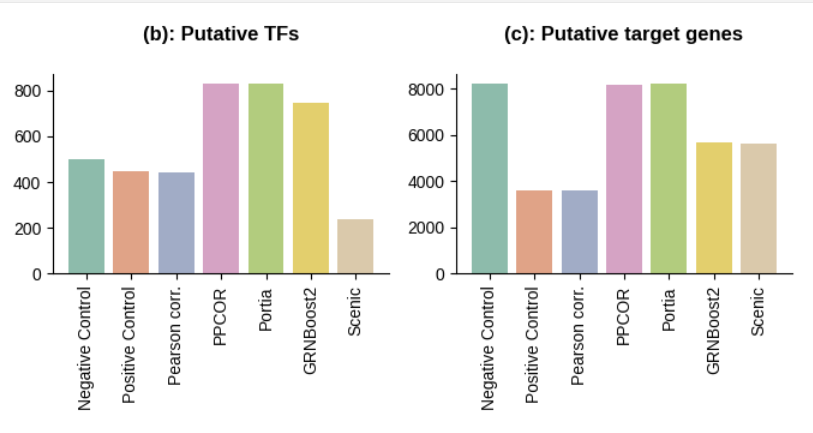

### nakatake

In [7]:
df_scores = pd.read_csv(f"resources/scores/nakatake/50000-skeleton_False-binarize_True-ridge.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,-0.000815,-0.000943,0.000648,0.024343,0.047426,7
positive_control,0.000333,0.000933,0.050172,0.195597,0.103299,1
pearson_corr,0.002183,0.006059,0.042007,0.177372,0.092215,3
portia,0.000026,0.001641,0.044538,0.094127,0.071015,4
ppcor,-0.000114,-0.000657,0.004380,0.028708,0.049842,6
grnboost2,-0.001190,-0.001845,0.023334,0.179273,0.144886,2
scenic,0.003915,0.006797,0.005719,0.078472,0.091197,5


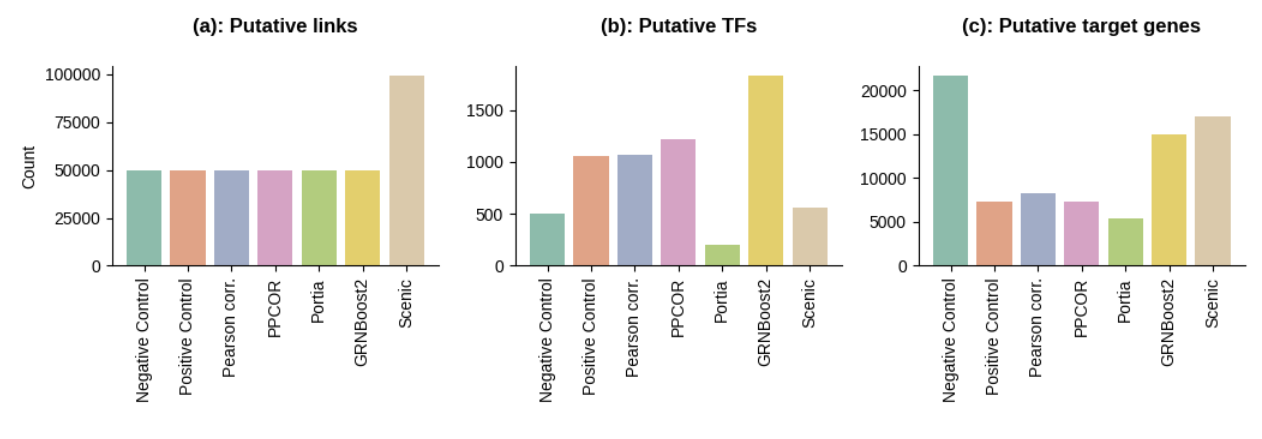

### norman 

In [8]:
df_scores = pd.read_csv(f"resources/scores/norman/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,-0.000234,-0.000256,0.014227,0.013110,0.003253,7
positive_control,-0.002901,-0.003470,0.136180,0.098129,0.040224,2
pearson_corr,0.001870,0.002176,0.135031,0.092110,0.036152,3
portia,-0.002051,-0.002247,0.064202,0.037832,0.009061,5
ppcor,0.001867,0.002047,0.093536,0.052257,0.011904,4
grnboost2,0.000263,0.000314,0.114651,0.101651,0.056132,1
scenic,0.001586,0.004122,0.084830,0.022496,0.005257,6


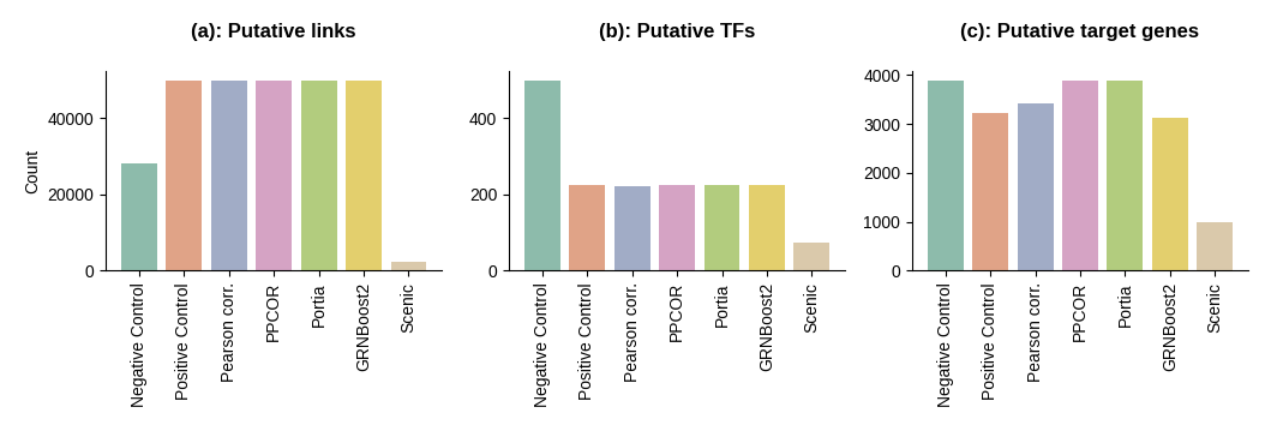

In [10]:
!ls resources/scores/adamson/

50000-skeleton_False-binarize_True-ridge.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv


### adamson

In [12]:
df_scores = pd.read_csv(f"resources/scores/adamson/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)
# df_scores[df_scores<0] = 0
df_scores_f = df_scores[['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']]
df_all_n = (df_scores_f-df_scores_f.min(axis=0))/(df_scores_f.max(axis=0)-df_scores_f.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
negative_control,0.022322,0.022322,0.445594,0.439009,0.413479,5
positive_control,-0.021639,-0.027437,0.664241,0.482923,0.436312,2
pearson_corr,0.024375,0.030097,0.652753,0.481473,0.435883,3
portia,-0.022940,-0.023618,0.341579,0.371780,0.401550,6
ppcor,-0.017781,-0.017927,0.555375,0.453831,0.423552,4
grnboost2,-0.011154,-0.013385,0.679135,0.503771,0.451201,1


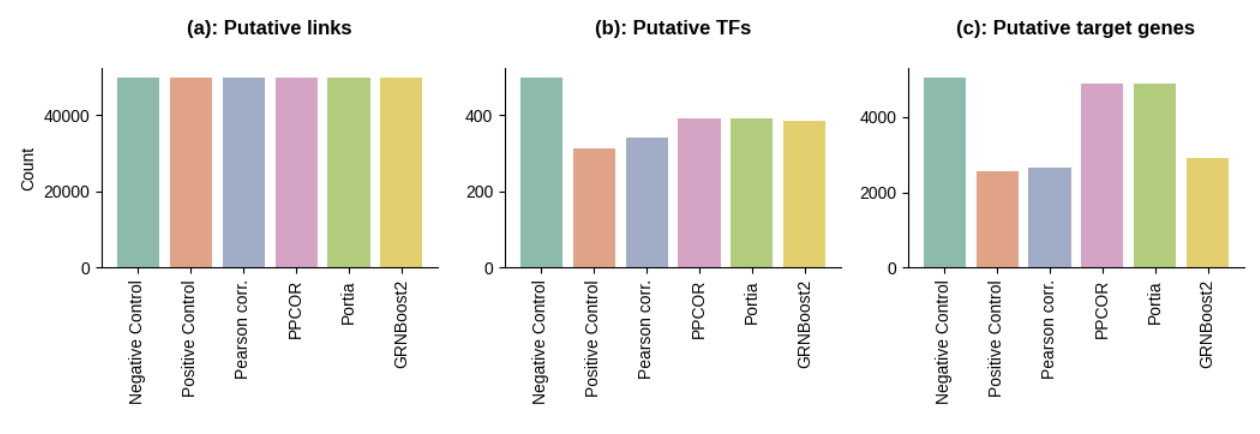

### Global models

In [119]:
!ls resources/scores/op/

50000-skeleton_False-binarize_True-GB.csv
50000-skeleton_False-binarize_True-ridge.csv
lognorm-50000-skeleton_False-binarize_True-ridge-global-False.csv
nets
X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv
X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv


In [121]:
df_scores_gb = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global-True.csv", index_col=0)
df_scores = pd.read_csv(f"resources/scores/op/X_norm-50000-skeleton_False-binarize_True-ridge-global-False.csv", index_col=0)

df_scores = pd.concat([df_scores, df_scores_gb])
# df_scores[df_scores<0] = 0
df_all_n = (df_scores-df_scores.min(axis=0))/(df_scores.max(axis=0)-df_scores.min(axis=0))
df_scores['rank'] = df_all_n.mean(axis=1).rank(ascending=False).astype(int)
df_scores.style.background_gradient()

,S1,S2,static-theta-0.0,static-theta-0.5,static-theta-1.0,rank
collectri,0.058315,0.126899,0.229779,0.272409,0.290769,13
negative_control,-0.000923,-0.000961,0.193640,0.260667,0.290877,19
positive_control,0.721750,1.188803,0.654297,0.411675,0.310124,2
pearson_corr,0.570333,1.048355,0.580583,0.379891,0.303594,4
portia,0.465527,0.674097,0.513885,0.317206,0.298095,7
ppcor,0.196689,0.238486,0.362190,0.289743,0.291190,10
grnboost2,0.735540,0.923076,0.581265,0.471491,0.329940,1
scenic,0.318873,0.467008,0.519103,0.406525,0.317489,6
granie,0.147522,0.193977,0.165400,0.211497,0.283239,21
scglue,0.155642,0.678908,0.499250,0.293863,0.293939,8


# Robustness analysis

In [25]:
if True:
    !sbatch scripts/sbatch/robustness_analysis.sh # !python src/robustness_analysis/script_all.py
base_dir = 'resources/results/robustness_analysis'

Submitted batch job 7770049


In [26]:
def format_robustness_results(base_dir, noise_type='net'):
    degrees = [0, 10, 20, 50, 100]
    reg1_metric = 'S1'
    reg2_metric = 'static-theta-0.5'
    for i, degree in enumerate(degrees):
        df = pd.read_csv(f'{base_dir}/{noise_type}-{degree}-scores.csv',index_col=0)
        df_reg1 = df.loc[:, [reg1_metric]].rename(columns={reg1_metric:degree})
        df_reg2 = df.loc[:, [reg2_metric]].rename(columns={reg2_metric:degree})
        
        if i == 0:
            reg1_scores = df_reg1
            reg2_scores = df_reg2
        else:
            reg1_scores = pd.concat([reg1_scores, df_reg1], axis=1)
            reg2_scores = pd.concat([reg2_scores, df_reg2], axis=1)
        
    reg1_scores = reg1_scores.T
    reg2_scores = reg2_scores.T
    return reg1_scores, reg2_scores

## Permute net

In [27]:
# net 
noise_type = 'net'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [28]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132838,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063194,-0.037703,0.258300,0.201382,0.094161,-0.016007,0.246858,0.117373,0.052529,0.046615,0.159076,0.085768,0.259247
20,-0.068023,-0.038826,0.232850,0.188608,0.076579,-0.025485,0.213148,0.103506,0.043782,0.037751,0.145942,0.079237,0.243952
50,-0.075000,-0.037746,0.182995,0.174772,0.020020,0.005844,0.099969,0.057258,0.005112,-0.019924,0.099687,0.052120,0.147341
100,-0.084617,-0.038591,-0.009365,-0.045844,-0.052908,-0.064681,-0.057610,-0.016075,-0.004035,-0.045894,-0.019244,-0.013468,-0.006252


In [29]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.337533,0.316130,0.501373,0.447392,0.268367,0.335675,0.467258,0.354542,0.514954
10,0.310607,0.300799,0.433080,0.427072,0.337533,0.314340,0.492975,0.439982,0.263060,0.334209,0.453522,0.356273,0.506758
20,0.312346,0.298023,0.428219,0.416558,0.334752,0.307381,0.481193,0.427551,0.268367,0.330640,0.444836,0.351414,0.498718
50,0.305605,0.301245,0.413182,0.397406,0.322203,0.301887,0.442722,0.399035,0.288905,0.320246,0.407539,0.344040,0.464195
100,0.295797,0.303241,0.379001,0.345088,0.291961,0.286424,0.293421,0.317192,0.318627,0.289704,0.310580,0.316354,0.321514


## Permute sign

In [30]:
noise_type = 'sign'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

In [31]:
reg1_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561
10,-0.063294,-0.037943,0.244253,0.175927,0.068840,-0.026427,0.225111,0.097068,0.043191,0.039099,0.130693,0.066178,0.232978
20,-0.078692,-0.037331,0.195138,0.143907,0.030350,-0.041580,0.162380,0.059698,0.023835,0.021276,0.078184,0.049052,0.183118
50,-0.080401,-0.034971,-0.016077,0.001196,-0.000673,0.006405,-0.085877,-0.047863,0.000526,-0.019741,0.010997,-0.007829,-0.006821
100,-0.052885,-0.038053,0.285482,0.227900,0.114365,-0.009030,0.277384,0.132916,0.065566,0.054329,0.177773,0.097069,0.275561


In [32]:
reg2_scores.style.background_gradient()

,collectri,negative_control,positive_control,pearson_corr,portia,ppcor,grnboost2,scenic,granie,scglue,celloracle,figr,scenicplus
0,0.314904,0.298416,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257013,0.335675,0.467258,0.354542,0.514954
10,0.315233,0.298546,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257063,0.335675,0.467258,0.354542,0.514954
20,0.315206,0.298645,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256943,0.335675,0.467258,0.354542,0.514954
50,0.315729,0.299033,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.256891,0.335675,0.467258,0.354542,0.514954
100,0.314412,0.298592,0.438187,0.434587,0.343306,0.316130,0.501373,0.447392,0.257129,0.335675,0.467258,0.354542,0.514954


## Permute weight

In [33]:
noise_type = 'weight'
reg1_scores, reg2_scores = format_robustness_results(base_dir, noise_type=noise_type)

# Effect of pseudobulking on performance

In [2]:
from src.helper import analyse_meta_cells
analyse_meta_cells(task_grn_inference_dir='./')

# Effect of imputation on performance

In [ ]:
from src.helper import analyse_imputation
analyse_imputation(task_grn_inference_dir='./')

# Causal versus correlations

In [14]:
from src.helper import analyse_causal
analyse_causal(task_grn_inference_dir='./')


convert to long dataframe
TF subsetting
(456, 25090)
----cross validate for default----


Processing groups: 100%|██████████| 5/5 [00:12<00:00,  2.41s/it]
GRN preprocessing: 25090it [00:00, 25373.48it/s]
ridge CV: 100%|██████████| 25090/25090 [00:02<00:00, 11765.42it/s]
GRN preprocessing: 25090it [00:00, 25339.89it/s]
ridge CV: 100%|██████████| 25090/25090 [01:55<00:00, 217.99it/s]

Static approach (theta=1):



GRN preprocessing: 25090it [00:00, 25640.46it/s]
ridge CV: 100%|██████████| 25090/25090 [06:10<00:00, 67.69it/s]


convert to long dataframe
(456, 25090)
----cross validate for default----


Processing groups: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]
GRN preprocessing: 25090it [00:11, 2215.38it/s]
ridge CV: 100%|██████████| 25090/25090 [00:02<00:00, 9352.85it/s] 
GRN preprocessing: 25090it [00:11, 2211.47it/s]
ridge CV: 100%|██████████| 25090/25090 [02:10<00:00, 191.63it/s]


Static approach (theta=1):


GRN preprocessing: 25090it [00:11, 2197.01it/s]
ridge CV:  21%|██        | 5145/25090 [01:17<05:00, 66.47it/s]

array(['ZNF354C', 'KLF12', 'ZNF143', ..., 'ZNF831', 'ZRSR2', 'ZSWIM1'],
      dtype='<U14')